# Graph Models

***
2 model types:
- graph autoencoder
- graph variational autoencoder

4 steps:
- model class definitions
- input data loading and processing
- training
- inference

***

layers adapted from [Kipf et al.](https://arxiv.org/abs/1609.02907)  
author: Kinga Anna Wozniak  

note: graph variational autoenoder takes input as multiple of batch size (train and validation set)

In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

# data preprocessing

In [3]:
def normalize_features(particles):
    idx_pt, idx_eta, idx_phi, idx_class = range(4)
    # min-max normalize pt
    particles[:,:,idx_pt] = (particles[:,:,idx_pt] - np.min(particles[:,:,idx_pt])) / (np.max(particles[:,:,idx_pt])-np.min(particles[:,:,idx_pt]))
    # standard normalize angles
    particles[:,:,idx_eta] = (particles[:,:,idx_eta] - np.mean(particles[:,:,idx_eta]))/np.std(particles[:,:,idx_eta])
    particles[:,:,idx_eta] = (particles[:,:,idx_eta] - np.mean(particles[:,:,idx_phi]))/np.std(particles[:,:,idx_phi])
    # min-max normalize class label
    particles[:,:,idx_class] = (particles[:,:,idx_class] - np.min(particles[:,:,idx_class])) / (np.max(particles[:,:,idx_class])-np.min(particles[:,:,idx_class]))
    return particles

In [4]:
def normalized_adjacency(A):
    D = np.array(np.sum(A, axis=2), dtype=np.float32) # compute outdegree (= rowsum)
    D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))
    D = np.asarray([np.diagflat(dd) for dd in D]) # and diagonalize
    return np.matmul(D, np.matmul(A, D))

In [5]:
def make_adjacencies(particles):
    real_p_mask = particles[:,:,0] > 0 # construct mask for real particles
    adjacencies = (real_p_mask[:,:,np.newaxis] * real_p_mask[:,np.newaxis,:]).astype('float32')
    return adjacencies

# model classes

## loss

In [13]:
### Latent Space Loss (KL-Divergence)
@tf.function
def kl_loss(z_mean, z_log_var):
    kl = 1. + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    return -0.5 * tf.reduce_mean(kl, axis=-1) # multiplying mse by N -> using sum (instead of mean) in kl loss

## layers

In [25]:
''' GC layers adapted from Kipf: https://github.com/tkipf/gae/blob/0ebbe9b9a8f496eb12deb9aa6a62e7016b5a5ac3/gae/layers.py '''

class GraphConvolution(tf.keras.layers.Layer):
    
    ''' basic graph convolution layer performing act(AXW) '''
    
    def __init__(self, output_sz, activation=tf.keras.activations.linear, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.output_sz = output_sz
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.output_sz], initializer=tf.keras.initializers.GlorotUniform())


    def call(self, inputs, adjacency):
        x = tf.matmul(inputs, self.kernel)
        x = tf.matmul(adjacency, x)
        return self.activation(x)

    def get_config(self):
        config = super(GraphConvolution, self).get_config()
        config.update({'output_sz': self.output_sz, 'activation': self.activation})
        return config


class InnerProductDecoder(tf.keras.layers.Layer):

    ''' inner product decoder reconstructing adjacency matrix as act(z^T z) 
        input assumed of shape [batch_sz x n_nodes x z_d]
        where 
            batch_sz can be 1 for single example feeding
            n_nodes ... number of nodes in graph
            z_d ... dimensionality of latent space
    '''

    def __init__(self, activation=tf.keras.activations.linear, **kwargs):
        super(InnerProductDecoder, self).__init__(**kwargs)
        self.activation = activation

    def call(self, inputs):
        perm = [0, 2, 1] if len(inputs.shape) == 3 else [1, 0]
        z_t = tf.transpose(inputs, perm=perm)
        adjacency_hat = tf.matmul(inputs, z_t)
        return self.activation(adjacency_hat)


    def get_config(self):
        config = super(InnerProductDecoder, self).get_config()
        return config


## graph autoencoder

In [27]:
class GraphAutoencoder(tf.keras.Model):

    def __init__(self, nodes_n, feat_sz, activation=tf.nn.tanh, **kwargs):
        super(GraphAutoencoder, self).__init__(**kwargs)
        self.nodes_n = nodes_n
        self.feat_sz = feat_sz
        self.input_shape_feat = [self.nodes_n, self.feat_sz]
        self.input_shape_adj = [self.nodes_n, self.nodes_n]
        self.activation = activation
        self.loss_fn = tf.nn.weighted_cross_entropy_with_logits
        self.encoder = self.build_encoder()
        self.decoder = InnerProductDecoder(activation=tf.keras.activations.linear) # if activation sigmoid -> return probabilities from logits


    def build_encoder(self):
        ''' reduce feat_sz to 2 '''
        inputs_feat = tf.keras.layers.Input(shape=self.input_shape_feat, dtype=tf.float32, name='encoder_input_features')
        inputs_adj = tf.keras.layers.Input(shape=self.input_shape_adj, dtype=tf.float32, name='encoder_input_adjacency')
        x = inputs_feat
        #feat_sz-1 layers needed to reduce to R^2 
        for output_sz in reversed(range(2, self.feat_sz)):
            x = GraphConvolution(output_sz=output_sz, activation=self.activation)(x, inputs_adj)
        x = GraphConvolution(output_sz=1, activation=tf.keras.activations.linear)(x, inputs_adj)
        encoder = tf.keras.Model(inputs=(inputs_feat, inputs_adj), outputs=x)
        encoder.summary()
        return encoder


    def call(self, inputs):
        z = self.encoder(inputs)
        adj_pred = self.decoder(z)
        return z, adj_pred

    def train_step(self, data):
        (X, adj_tilde), adj_orig = data
        # pos_weight = zero-adj / one-adj -> no-edge vs edge ratio
        pos_weight = tf.cast(adj_orig.shape[1] * adj_orig.shape[2] - tf.math.reduce_sum(adj_orig), tf.float32) / tf.cast(tf.math.reduce_sum(adj_orig), tf.float32)

        with tf.GradientTape() as tape:
            z, adj_pred = self((X, adj_tilde))  # Forward pass
            # Compute the loss value (binary cross entropy for a_ij in {0,1})
            loss = self.loss_fn(labels=adj_orig, logits=adj_pred, pos_weight=pos_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


    def test_step(self, data):
        (X, adj_tilde), adj_orig = data
        pos_weight = tf.cast(adj_orig.shape[1] * adj_orig.shape[2] - tf.math.reduce_sum(adj_orig), tf.float32) / tf.cast(tf.math.reduce_sum(adj_orig), tf.float32)

        z, adj_pred = self((X, adj_tilde), training=False)  # Forward pass
        loss = tf.math.reduce_mean(self.loss_fn(labels=adj_orig, logits=adj_pred, pos_weight=pos_weight)) # TODO: add regularization
        
        return {'loss' : loss}


## variational graph autoencoder

In [74]:
class GraphVariationalAutoencoder(GraphAutoencoder):
    
    def __init__(self, nodes_n, feat_sz, activation, **kwargs):
        super(GraphVariationalAutoencoder, self).__init__(nodes_n, feat_sz, activation, **kwargs)
        self.loss_fn_latent = kl_loss

    def build_encoder(self):

        ''' reduce feat_sz to 2 '''
        inputs_feat = tf.keras.layers.Input(shape=self.input_shape_feat, dtype=tf.float32, name='encoder_input_features')
        inputs_adj = tf.keras.layers.Input(shape=self.input_shape_adj, dtype=tf.float32, name='encoder_input_adjacency')
        x = inputs_feat

        for output_sz in reversed(range(2, self.feat_sz)):
            x = GraphConvolution(output_sz=output_sz, activation=self.activation)(x, inputs_adj)

        ''' make latent space params mu and sigma in last compression to feat_sz = 1 '''
        self.z_mean = GraphConvolution(output_sz=1, activation=tf.keras.activations.linear)(x, inputs_adj)
        self.z_log_var = GraphConvolution(output_sz=1, activation=tf.keras.activations.linear)(x, inputs_adj)

        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(self.z_mean)[0], self.nodes_n, 1))
        self.z = self.z_mean +  epsilon * tf.exp(0.5 * self.z_log_var)

        return tf.keras.Model(inputs=(inputs_feat, inputs_adj), outputs=[self.z, self.z_mean, self.z_log_var])
    
    
    def call(self, inputs):
        z, z_mean, z_log_var = self.encoder(inputs)
        adj_pred = self.decoder(z)
        return z, z_mean, z_log_var, adj_pred
    
    def train_step(self, data):
        (X, adj_tilde), adj_orig = data
        pos_weight = tf.cast(adj_orig.shape[1] * adj_orig.shape[2] - tf.math.reduce_sum(adj_orig), tf.float32) / tf.cast(tf.math.reduce_sum(adj_orig), tf.float32)


        with tf.GradientTape() as tape:
            z, z_mean, z_log_var, adj_pred = self((X, adj_tilde))  # Forward pass
            # Compute the loss value (binary cross entropy for a_ij in {0,1})
            loss_reco = tf.math.reduce_mean(self.loss_fn(labels=adj_orig, logits=adj_pred, pos_weight=pos_weight), axis=(1,2)) # TODO: add regularization
            loss_latent = tf.math.reduce_mean(self.loss_fn_latent(z_mean, z_log_var), axis=1)
            loss = loss_reco + loss_latent

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Return a dict mapping metric names to current value
        return {'loss' : loss_reco+loss_latent, 'loss_reco': loss_reco, 'loss_latent': loss_latent}


    def test_step(self, data):
        (X, adj_tilde), adj_orig = data
        pos_weight = tf.cast(adj_orig.shape[1] * adj_orig.shape[2] - tf.math.reduce_sum(adj_orig), tf.float32) / tf.cast(tf.math.reduce_sum(adj_orig), tf.float32)

        z, z_mean, z_log_var, adj_pred = self((X, adj_tilde))  # Forward pass
        # Compute the loss value (binary cross entropy for a_ij in {0,1})
        loss_reco =  tf.math.reduce_mean(self.loss_fn(labels=adj_orig, logits=adj_pred, pos_weight=pos_weight)) # TODO: add regularization
        loss_latent = tf.math.reduce_mean(self.loss_fn_latent(z_mean, z_log_var))
        
        return {'loss' : loss_reco+loss_latent, 'loss_reco': loss_reco, 'loss_latent': loss_latent}

# load data

In [16]:
# set the correct background filename
filename = 'background.h5'
ff = h5py.File(filename, 'r')
particles = np.asarray(ff.get('Particles'))

In [17]:
particles.shape

(500000, 19, 4)

In [18]:
nodes_n = particles.shape[1]
feat_sz = particles.shape[2]

In [49]:
# features: array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')
batch_size = 128
particles_train = particles[:batch_size*20]

In [50]:
A = make_adjacencies(particles_train)
A_tilde = normalized_adjacency(A)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'pt')

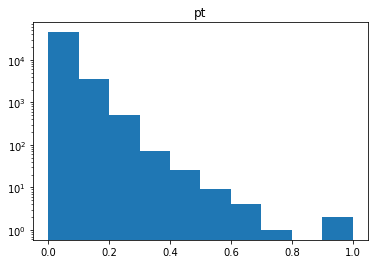

In [51]:
plt.hist(particles_train[:,:,0].flatten())
plt.yscale('log')
plt.title('pt')

In [52]:
particles_train = normalize_features(particles_train)

Text(0.5, 1.0, 'normalized pt')

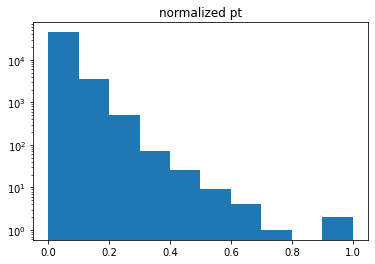

In [53]:
plt.hist(particles_train[:,:,0].flatten())
plt.yscale('log')
plt.title('normalized pt')

# build model: Autoencoder

In [54]:
gnn = GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 19, 4)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 19, 19)]     0                                            
__________________________________________________________________________________________________
graph_convolution_7 (GraphConvo (None, 19, 3)        12          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_8 (GraphConvo (None, 19, 2)        6           graph_convolution_7[0]

# train model

In [55]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)]
gnn.fit((particles_train, A_tilde), A, epochs=100, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 0s 15ms/step - val_loss: 0.6739
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - val_loss: 0.6739
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - val_loss: 0.6738
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - val_loss: 0.6738
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - val_loss: 0.6738
Epoch 8/100
15/15 [==============================] - 0s 13ms/step - val_loss: 0.6738
Epoch 9/100
14/15 [===========================>..] - ETA: 0s
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 10/100
15/15 [==============================] - 0s 25ms/step - val_loss: 0.6738
Epoch 11/100
15/15 [=

15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 76/100
15/15 [==============================] - 0s 13ms/step - val_loss: 0.6738
Epoch 77/100
15/15 [==============================] - 0s 12ms/step - val_loss: 0.6738
Epoch 78/100
15/15 [==============================] - 0s 12ms/step - val_loss: 0.6738
Epoch 79/100
11/15 [=====================>........] - ETA: 0s
Epoch 00079: ReduceLROnPlateau reducing learning rate to 3.0517577442878974e-07.
15/15 [==============================] - 0s 12ms/step - val_loss: 0.6738
Epoch 80/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 81/100
15/15 [==============================] - 0s 15ms/step - val_loss: 0.6738
Epoch 82/100
15/15 [==============================] - 0s 14ms/step - val_loss: 0.6738
Epoch 83/100
15/15 [==============================] - 0s 16ms/step - val_loss: 0.6738
Epoch 84/100
12/15 [=======================>......] - ETA: 0s
Epoch 00084: ReduceLROnPlateau reducing learnin

# predict background

In [56]:
particles_test = particles[3000:4000]
A_test = make_adjacencies(particles_test)
A_tilde_test = normalized_adjacency(A_test)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
z, A_pred = gnn((particles_test, A_tilde_test))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [58]:
A_reco = (tf.nn.sigmoid(A_pred) > 0.5).numpy().astype('int') 

In [59]:
loss_background = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_test, A_pred), axis=(1,2))

In [60]:
np.mean(loss_background)

0.6930421

# load and predict signal

In [61]:
# set the correct signal filename 
filename = 'signal_file'
ff = h5py.File(filename, 'r')
particles_signal = np.asarray(ff.get('Particles'))

In [62]:
particles_signal.shape

(691283, 19, 4)

In [63]:
# features: array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')
particles_signal_test = particles_signal[:3000]

In [64]:
A_signal = make_adjacencies(particles_signal_test)
A_tilde_signal = normalized_adjacency(A_signal)

/home/kinga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


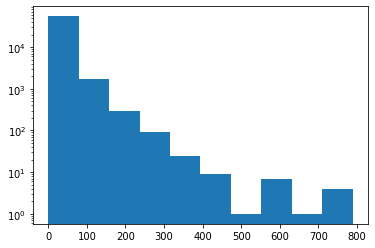

In [65]:
plt.hist(particles_signal_test[:,:,0].flatten())
plt.yscale('log')

In [66]:
particles_signal_test = normalize_features(particles_signal_test)

Text(0.5, 1.0, 'normalized pt')

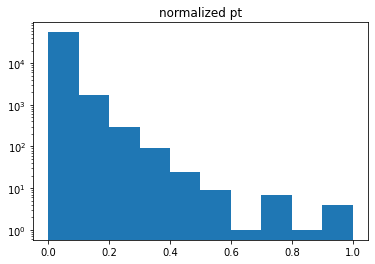

In [67]:
plt.hist(particles_signal_test[:,:,0].flatten())
plt.yscale('log')
plt.title('normalized pt')

In [68]:
z_signal, A_pred_signal = gnn((particles_signal_test, A_tilde_signal))

In [69]:
A_reco_signal = (tf.nn.sigmoid(A_pred_signal) > 0.5).numpy().astype('int') 

In [70]:
loss_signal = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_signal, A_pred_signal), axis=(1,2))

In [71]:
np.mean(loss_signal)

0.69312567

# build model: Variational Autoencoder

In [76]:
gnn = GraphVariationalAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

# train model

In [77]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)]
gnn.fit((particles_train, A_tilde), A, epochs=100, batch_size=batch_size, validation_split=0.25, callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 0s 24ms/step - loss: 0.8048 - loss_reco: 0.8033 - loss_latent: 0.0015 - val_loss: 0.8070 - val_loss_reco: 0.8067 - val_loss_latent: 2.8398e-04
Epoch 2/100
15/15 [==============================] - 0s 22ms/step - loss: 0.8015 - loss_reco: 0.8014 - loss_latent: 1.1290e-04 - val_loss: 0.7963 - val_loss_reco: 0.7962 - val_loss_latent: 2.3983e-05
Epoch 3/100
15/15 [==============================] - 0s 23ms/step - loss: 0.8014 - loss_reco: 0.8014 - loss_latent: 5.3270e-05 - val_loss: 0.8049 - val_loss_reco: 0.8048 - val_loss_latent: 9.3976e-05
Epoch 4/100
15/15 [==============================] - 0s 21ms/step - loss: 0.7993 - loss_reco: 0.7989 - loss_latent: 3.4072e-04 - val_loss: 0.7990 - val_loss_reco: 0.7984 - val_loss_latent: 5.8588e-04
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 0.7996 - loss_reco: 0.7982 - loss_latent: 0.0014 - val_loss: 0.8017 - val_loss_reco: 0.7998 - val_loss_latent: 0.0019
Epoch 6/100


13/15 [=========================>....] - ETA: 0s - loss: 0.7982 - loss_reco: 0.7961 - loss_latent: 0.0021
Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
15/15 [==============================] - 0s 30ms/step - loss: 0.7984 - loss_reco: 0.7963 - loss_latent: 0.0021 - val_loss: 0.8007 - val_loss_reco: 0.7987 - val_loss_latent: 0.0020
Epoch 39/100
15/15 [==============================] - 0s 28ms/step - loss: 0.8013 - loss_reco: 0.7992 - loss_latent: 0.0021 - val_loss: 0.8024 - val_loss_reco: 0.8004 - val_loss_latent: 0.0020
Epoch 40/100
15/15 [==============================] - 0s 28ms/step - loss: 0.7975 - loss_reco: 0.7954 - loss_latent: 0.0021 - val_loss: 0.7990 - val_loss_reco: 0.7971 - val_loss_latent: 0.0020
Epoch 41/100
15/15 [==============================] - 0s 28ms/step - loss: 0.7990 - loss_reco: 0.7969 - loss_latent: 0.0021 - val_loss: 0.8114 - val_loss_reco: 0.8095 - val_loss_latent: 0.0020
Epoch 42/100
15/15 [==============================] - 

Epoch 74/100
15/15 [==============================] - 0s 21ms/step - loss: 0.7960 - loss_reco: 0.7939 - loss_latent: 0.0021 - val_loss: 0.7941 - val_loss_reco: 0.7921 - val_loss_latent: 0.0020
Epoch 75/100
15/15 [==============================] - ETA: 0s - loss: 0.7973 - loss_reco: 0.7952 - loss_latent: 0.0021
Epoch 00075: ReduceLROnPlateau reducing learning rate to 1.220703097715159e-06.
15/15 [==============================] - 0s 30ms/step - loss: 0.7981 - loss_reco: 0.7960 - loss_latent: 0.0021 - val_loss: 0.7898 - val_loss_reco: 0.7878 - val_loss_latent: 0.0020
Epoch 76/100
15/15 [==============================] - 0s 28ms/step - loss: 0.7999 - loss_reco: 0.7977 - loss_latent: 0.0021 - val_loss: 0.7975 - val_loss_reco: 0.7955 - val_loss_latent: 0.0020
Epoch 77/100
15/15 [==============================] - 0s 22ms/step - loss: 0.7953 - loss_reco: 0.7931 - loss_latent: 0.0021 - val_loss: 0.7991 - val_loss_reco: 0.7971 - val_loss_latent: 0.0020
Epoch 78/100
15/15 [======================

# predict background

In [78]:
z, z_mean, z_log_var, A_pred = gnn((particles_test, A_tilde_test))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [79]:
A_reco = (tf.nn.sigmoid(A_pred) > 0.5).numpy().astype('int') 

In [80]:
loss_background_reco = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_test, A_pred), axis=(1,2))

In [82]:
loss_background_latent = kl_loss(z_mean, z_log_var)

In [83]:
np.mean(loss_background_reco)

0.8112967

In [84]:
np.mean(loss_background_latent)

0.0036986305

# predict signal

In [85]:
z_signal, z_mean_signal, z_log_var_signal, A_pred_signal = gnn((particles_signal_test, A_tilde_signal))

In [86]:
A_reco_signal = (tf.nn.sigmoid(A_pred_signal) > 0.5).numpy().astype('int') 

In [87]:
loss_signal_reco = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_signal, A_pred_signal), axis=(1,2))

In [88]:
loss_signal_latent = kl_loss(z_mean_signal, z_log_var_signal)

In [89]:
np.mean(loss_signal_reco)

0.8038542

In [90]:
np.mean(loss_signal_latent)

0.005094626